# Credit Card Fraud

Quels facteurs sur les transactions bancaires nous permettent de prédire une fraude à la carte bancaire ?

- EDA
- Preprocessing (ACP, feature selection)
- Modèles :
-* ML supervisé de classification binaire avec régression logistique, RandomForest, (régression linéaire pour les montants) ;
-* ML non supervisé avec clustering géographique DBScan Elbow+Silhouette
- Confrontation des résultats (quel serait le meilleur modèle pour prédire la fraude)
- Exemple de prédiction
- Mise en place du dashboard
- Proposer des questions d'ouverture (pour la présentation)

Si on a le temps : prédire le montant de la fraude (régression linéaire)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
#pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE

In [2]:
data = pd.read_csv('src/fraud test.csv')
data.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,21/06/2020 12:14,2.291160e+15,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,19/03/1968,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,21/06/2020 12:14,3.573030e+15,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",17/01/1990,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,21/06/2020 12:14,3.598220e+15,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",21/10/1970,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,21/06/2020 12:15,3.591920e+15,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,25/07/1987,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,21/06/2020 12:15,3.526830e+15,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,06/07/1955,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


#### Cleansing

In [3]:
def data_cleanse(data_sample):
    '''On retire les colonnes qui ne sont pas pertinentes
        cc_num, trans_num, first, last et {city, state, street, zip} = infos individuelles trop de valeurs différentes
        merchant = idem
        Unnamed: 0 = index, des identifiants donc à supprimer
        unix_time = temps Unix, redondant'''
    colonne_a_retirer = ['cc_num', 'first', 'last', 'city', 'state', 'street', 'zip', 'trans_num', 'Unnamed: 0', 'merchant', 'unix_time', 'lat', 'long']
    df = data_sample.drop(colonne_a_retirer, axis=1)
    df["trans_date_trans_time"]=pd.to_datetime(df["trans_date_trans_time"], format= "%d/%m/%Y %H:%M")
    df["dob"]=pd.to_datetime(df["dob"], format= "%d/%m/%Y")

    annee_actuelle = pd.Timestamp.now().year
    df['age'] = annee_actuelle - df["dob"].dt.year

    df["day_of_the_week"]=df["trans_date_trans_time"].dt.weekday
    df["month"]=df["trans_date_trans_time"].dt.month
    df["day"]=df["trans_date_trans_time"].dt.day
    df["year"]=df["trans_date_trans_time"].dt.year
    df["hour"]=df["trans_date_trans_time"].dt.hour

    colonne_a_retirer = ['trans_date_trans_time', 'dob']
    df = df.drop(colonne_a_retirer, axis=1)
    return df

#### Sample

In [5]:
data_sample = data.sample(frac=0.1, random_state=0)
df = data_cleanse(data_sample)

In [6]:
df.head()

,category,amt,gender,city_pop,job,merch_lat,merch_long,is_fraud,age,day_of_the_week,month,day,year,hour
102051,grocery_pos,218.76,F,3285,"Research officer, trade union",40.153684,-73.445235,0,36,0,7,27,2020,1
270705,grocery_net,48.83,M,95,Electrical engineer,46.699574,-84.995269,0,30,1,9,29,2020,10
308877,home,70.86,M,1201,"Engineer, agricultural",36.439648,-92.203914,0,44,4,10,16,2020,14
465523,misc_pos,4.74,M,23805,Copy,41.901153,-83.097443,0,54,5,12,12,2020,9
358267,shopping_pos,9.75,F,1766,Press sub,30.197385,-98.101702,0,48,5,11,7,2020,12


### Model selection evaluation

#### Preprocessings

On reprend les preprocessings du baseline model

In [7]:
categorical_features = ['category', 'gender']
numerical_features = ['age', 'day', 'month', 'day_of_the_week', 'city_pop', 'merch_lat', 'merch_long', 'amt']
features = categorical_features + numerical_features
target = 'is_fraud'

X = df.loc[:,features]
y = df.loc[:,target]

#### Régression logistique

In [8]:
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, train_size=0.7, random_state=0, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=0, stratify=y_valtest)

In [9]:
categorical_transformer = OneHotEncoder(drop="first")

numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(transformers=[
    ('categorical', categorical_transformer, categorical_features),
    ('numerical', numeric_transformer, numerical_features)
])

smotenc = SMOTENC(categorical_features=[0, 1])

pipeline_reglog = ImbPipeline([("preprocessor", preprocessor),
                        ("smote", smotenc),
                        ("classifier", LogisticRegression(class_weight='balanced', max_iter=1000))])
pipeline_reglog.fit(X_train, y_train)

y_train_pred = pipeline_reglog.predict(X_train)
y_val_pred = pipeline_reglog.predict(X_val)

In [10]:
print(classification_report(y_train, y_train_pred))
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93     38751
           1       0.02      0.78      0.04       149

    accuracy                           0.87     38900
   macro avg       0.51      0.82      0.49     38900
weighted avg       1.00      0.87      0.92     38900

              precision    recall  f1-score   support

           0       1.00      0.87      0.93      8304
           1       0.02      0.75      0.04        32

    accuracy                           0.87      8336
   macro avg       0.51      0.81      0.48      8336
weighted avg       1.00      0.87      0.92      8336



#### RandomForest

In [20]:
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, train_size=0.7, random_state=0, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=0, stratify=y_valtest)

In [21]:
categorical_transformer = OneHotEncoder(drop="first")

numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(transformers=[
    ('categorical', categorical_transformer, categorical_features),
    ('numerical', numeric_transformer, numerical_features)
])

smotenc = SMOTENC(categorical_features=[0, 1])

pipeline_rf = ImbPipeline([("preprocessor", preprocessor),
                           ("smote", smotenc),
                           ("classifier", RandomForestClassifier(class_weight='balanced',
                                                                 max_depth=15,
                                                                 min_samples_leaf=5,
                                                                 min_samples_split=16))])
pipeline_rf.fit(X_train, y_train)

y_train_pred = pipeline_rf.predict(X_train)
y_val_pred = pipeline_rf.predict(X_val)
print(classification_report(y_train, y_train_pred))
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     38751
           1       0.65      0.82      0.72       149

    accuracy                           1.00     38900
   macro avg       0.82      0.91      0.86     38900
weighted avg       1.00      1.00      1.00     38900

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8304
           1       0.67      0.50      0.57        32

    accuracy                           1.00      8336
   macro avg       0.83      0.75      0.78      8336
weighted avg       1.00      1.00      1.00      8336



#### SVM

In [13]:
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, train_size=0.7, random_state=0, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=0, stratify=y_valtest)

In [14]:
categorical_transformer = OneHotEncoder(drop="first")

numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(transformers=[
    ('categorical', categorical_transformer, categorical_features),
    ('numerical', numeric_transformer, numerical_features)
])

smotenc = SMOTENC(categorical_features=[0, 1])

pipeline_svc = ImbPipeline([("preprocessor", preprocessor),
                        ("smote", smotenc),
                        ("classifier", SVC(class_weight='balanced'))])
pipeline_svc.fit(X_train, y_train)

y_train_pred = pipeline_svc.predict(X_train)
y_val_pred = pipeline_svc.predict(X_val)
print(classification_report(y_train, y_train_pred))
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     38751
           1       0.17      0.93      0.28       149

    accuracy                           0.98     38900
   macro avg       0.58      0.95      0.64     38900
weighted avg       1.00      0.98      0.99     38900

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      8304
           1       0.09      0.50      0.15        32

    accuracy                           0.98      8336
   macro avg       0.54      0.74      0.57      8336
weighted avg       0.99      0.98      0.99      8336



#### SVM (gridsearch)

In [15]:
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, train_size=0.7, random_state=0, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=0, stratify=y_valtest)

In [16]:
categorical_transformer = OneHotEncoder(drop="first")

numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(transformers=[
    ('categorical', categorical_transformer, categorical_features),
    ('numerical', numeric_transformer, numerical_features)
])

smotenc = SMOTENC(categorical_features=[0, 1])

pipeline = ImbPipeline([("preprocessor", preprocessor),
                        ("smote", smotenc),
                        ("classifier", SVC(class_weight='balanced'))])

# Paramètres à tester
param_grid = {
    'classifier__C': [0.1, 1, 10],
}

# Création et exécution de la recherche par grille
gridsearch = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1')
gridsearch.fit(X_train, y_train)

y_train_pred = gridsearch.predict(X_train)
y_val_pred = gridsearch.predict(X_val)
print("Best parameters:", gridsearch.best_params_)
print("Best cross-validation score: {:.2f}".format(gridsearch.best_score_))

Best parameters: {'classifier__C': 10}
Best cross-validation score: 0.26


In [17]:
print(classification_report(y_train, y_train_pred))
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     38751
           1       0.34      0.95      0.50       149

    accuracy                           0.99     38900
   macro avg       0.67      0.97      0.75     38900
weighted avg       1.00      0.99      0.99     38900

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      8304
           1       0.16      0.47      0.24        32

    accuracy                           0.99      8336
   macro avg       0.58      0.73      0.62      8336
weighted avg       0.99      0.99      0.99      8336



#### Reprise du Random Forest en ajoutant la feature "hour"

In [69]:
data_sample = data.sample(frac=0.1, random_state=1)
df = data_cleanse(data_sample)

categorical_features = ['category', 'gender']
numerical_features = ['age', 'hour', 'day', 'month', 'day_of_the_week', 'city_pop', 'merch_lat', 'merch_long', 'amt']
features = categorical_features + numerical_features
target = 'is_fraud'

X = df.loc[:,features]
y = df.loc[:,target]

categorical_transformer = OneHotEncoder(drop="first")

numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(transformers=[
    ('categorical', categorical_transformer, categorical_features),
    ('numerical', numeric_transformer, numerical_features)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0, stratify=y)

smotenc = SMOTENC(categorical_features=[0, 1])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

X_train, y_train = smotenc.fit_resample(X_train, y_train)

classifier = RandomForestClassifier(class_weight='balanced',
                                    max_depth=12,
                                    min_samples_leaf=15,
                                    min_samples_split=16,
                                    n_estimators=100)

classifier.fit(X_train, y_train)

y_train_pred = classifier.predict(X_train)
y_test_pred = classifier.predict(X_test)
print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     38732
           1       1.00      1.00      1.00     38732

    accuracy                           1.00     77464
   macro avg       1.00      1.00      1.00     77464
weighted avg       1.00      1.00      1.00     77464

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16600
           1       0.41      0.65      0.50        72

    accuracy                           0.99     16672
   macro avg       0.70      0.82      0.75     16672
weighted avg       1.00      0.99      1.00     16672



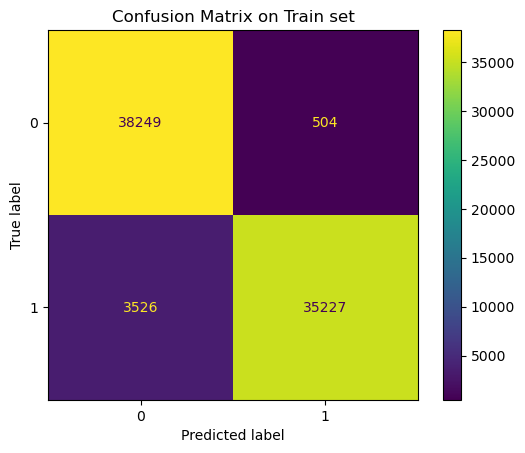

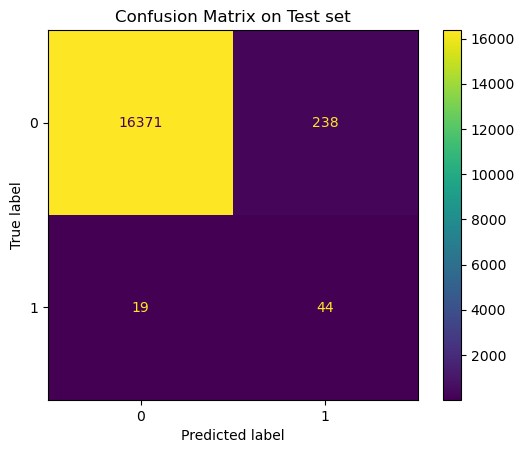

In [49]:
# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_train, y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_test, y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

#### Sur le dataset complet

- Ne pas sample
- Train test split : en train + test
- Gridsearch sur RandomForest
- Faire de même pour XGBoost
- Pipeline : sur le train, data augmentation ; mais sur le test, même pipeline sauf la data augmentation
- data augmentation : fit uniquement ?

- Si trop de temps : train val test split
- Val set intéressant pour le GridSearch pour rechercher les hyperparamètres

In [70]:
data_sample = data.sample(frac=1., random_state=33)

In [71]:
df = data_cleanse(data_sample)

categorical_features = ['category', 'gender']
numerical_features = ['age', 'hour', 'day', 'month', 'day_of_the_week', 'city_pop', 'merch_lat', 'merch_long', 'amt']
features = categorical_features + numerical_features
target = 'is_fraud'

X = df.loc[:,features]
y = df.loc[:,target]

In [72]:
X.head()

,category,gender,age,hour,day,month,day_of_the_week,city_pop,merch_lat,merch_long,amt
190013,home,M,40,16,26,8,2,207410,39.453417,-77.097096,16.40
478823,personal_care,M,21,20,14,12,0,5666,31.756447,-83.186188,1.24
55737,health_fitness,M,38,18,10,7,4,2501,33.792156,-93.656204,17.88
240568,kids_pets,F,49,21,15,9,1,320420,39.784314,-105.568555,13.04
234197,home,F,52,21,13,9,6,11256,38.191697,-123.155185,30.53


In [73]:
# Définition des transformations

categorical_transformer = OneHotEncoder(drop="first")

numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(transformers=[
    ('categorical', categorical_transformer, categorical_features),
    ('numerical', numeric_transformer, numerical_features)
])

smotenc = SMOTENC(categorical_features=[0, 1])

# Train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0, stratify=y)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

X_train, y_train = smotenc.fit_resample(X_train, y_train)

# Déclaration du modèle

classifier_rf = RandomForestClassifier(class_weight='balanced')

# Définition des paramètres du gridsearch

params = {
    "max_depth": [5, 10, 15],
    "min_samples_leaf": [10, 12, 14],
    "min_samples_split": [16, 20, 24],
    "n_estimators": [50, 80, 100],
}

# Gridsearch

print("Grid search...")
gridsearch_rf = GridSearchCV(
    classifier_rf, param_grid=params, cv=3, scoring='f1'
)
gridsearch_rf.fit(X_train, y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch_rf.best_params_)
print("Best validation F1-score : ", gridsearch_rf.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'max_depth': 15, 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 80}
Best validation F1-score :  0.9922115717818816


In [74]:
y_train_pred = gridsearch_rf.predict(X_train)
y_test_pred = gridsearch_rf.predict(X_test)
print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    387502
           1       1.00      0.99      0.99    387502

    accuracy                           0.99    775004
   macro avg       0.99      0.99      0.99    775004
weighted avg       0.99      0.99      0.99    775004

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    166072
           1       0.39      0.84      0.53       644

    accuracy                           0.99    166716
   macro avg       0.69      0.92      0.76    166716
weighted avg       1.00      0.99      1.00    166716



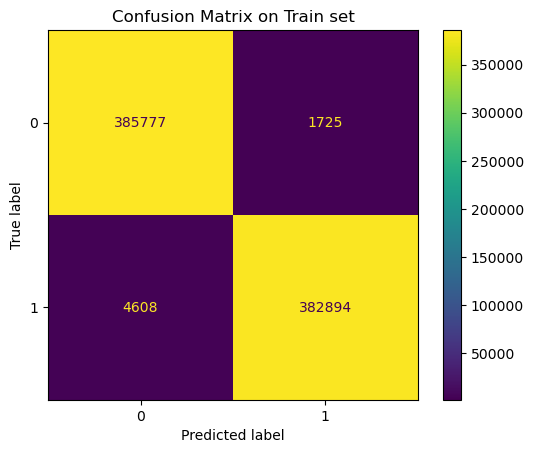

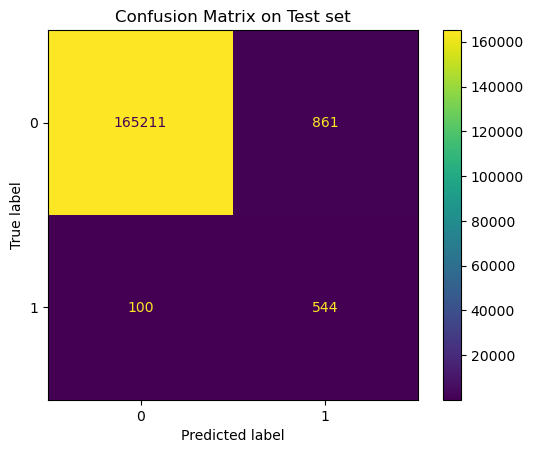

In [75]:
# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearch_rf, X_train, y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearch_rf, X_test, y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

#### XGBoost

In [4]:
data_sample = data.sample(frac=1., random_state=27)

In [5]:
df = data_cleanse(data_sample)

categorical_features = ['category', 'gender']
numerical_features = ['age', 'hour', 'day', 'month', 'day_of_the_week', 'city_pop', 'merch_lat', 'merch_long', 'amt']
features = categorical_features + numerical_features
target = 'is_fraud'

X = df.loc[:,features]
y = df.loc[:,target]

In [6]:
# Définition des transformations

categorical_transformer = OneHotEncoder(drop="first")

numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(transformers=[
    ('categorical', categorical_transformer, categorical_features),
    ('numerical', numeric_transformer, numerical_features)
])

smotenc = SMOTENC(categorical_features=[0, 1])

# Train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0, stratify=y)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

X_train, y_train = smotenc.fit_resample(X_train, y_train)

# Déclaration du modèle

classifier_xgb = XGBClassifier()

# Définition des paramètres du gridsearch

params = {
    "max_depth": [2, 6, 10, 15],
    "min_child_weight": [1, 2, 3, 4, 5, 6],
    "n_estimators": [4, 8, 12, 16, 20]
}

# Gridsearch

print("Grid search...")
gridsearch_xgb = GridSearchCV(
    classifier_xgb, param_grid=params, cv=3, scoring='f1'
)
gridsearch_xgb.fit(X_train, y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch_xgb.best_params_)
print("Best validation F1-score : ", gridsearch_xgb.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'max_depth': 15, 'min_child_weight': 1, 'n_estimators': 20}
Best validation F1-score :  0.9990958747513222


In [7]:
y_train_pred = gridsearch_xgb.predict(X_train)
y_test_pred = gridsearch_xgb.predict(X_test)
print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    387502
           1       1.00      1.00      1.00    387502

    accuracy                           1.00    775004
   macro avg       1.00      1.00      1.00    775004
weighted avg       1.00      1.00      1.00    775004

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    166072
           1       0.75      0.84      0.79       644

    accuracy                           1.00    166716
   macro avg       0.87      0.92      0.89    166716
weighted avg       1.00      1.00      1.00    166716



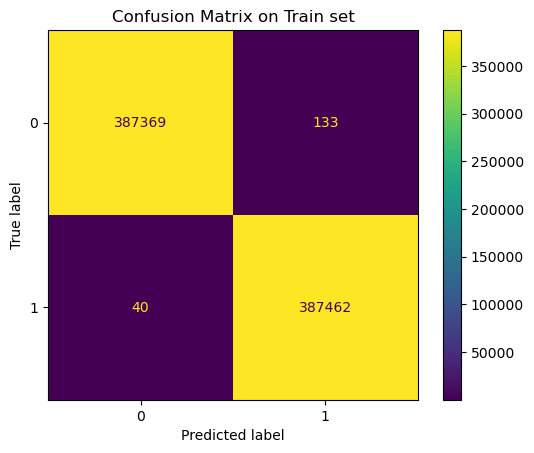

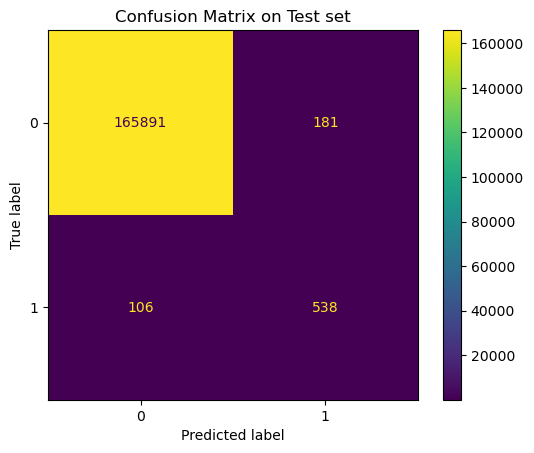

In [8]:
# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearch_xgb, X_train, y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearch_xgb, X_test, y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()